# Cancer rates modelling
Following is an experiment at modelling cancer rates from Gelman et. al BDA3 (section 2.7).
We are modelling the kidney cancer rates on a scale of individual county in US in the period od 1980-89.

In [1]:
import scipy.stats as stats
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
from cmdstanpy import CmdStanModel

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"


plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

import pandas as pd

We will be modelling cancer deaths with poisson distribution dependent on population size over 10 year period

$$ y_i\propto \mathrm{Poisson} (10 n_i \theta_i) $$

we will use an informative proior on cancer death rate i.e

$$
\theta_i\propto \mathrm{Gamma}(20,430000)
$$

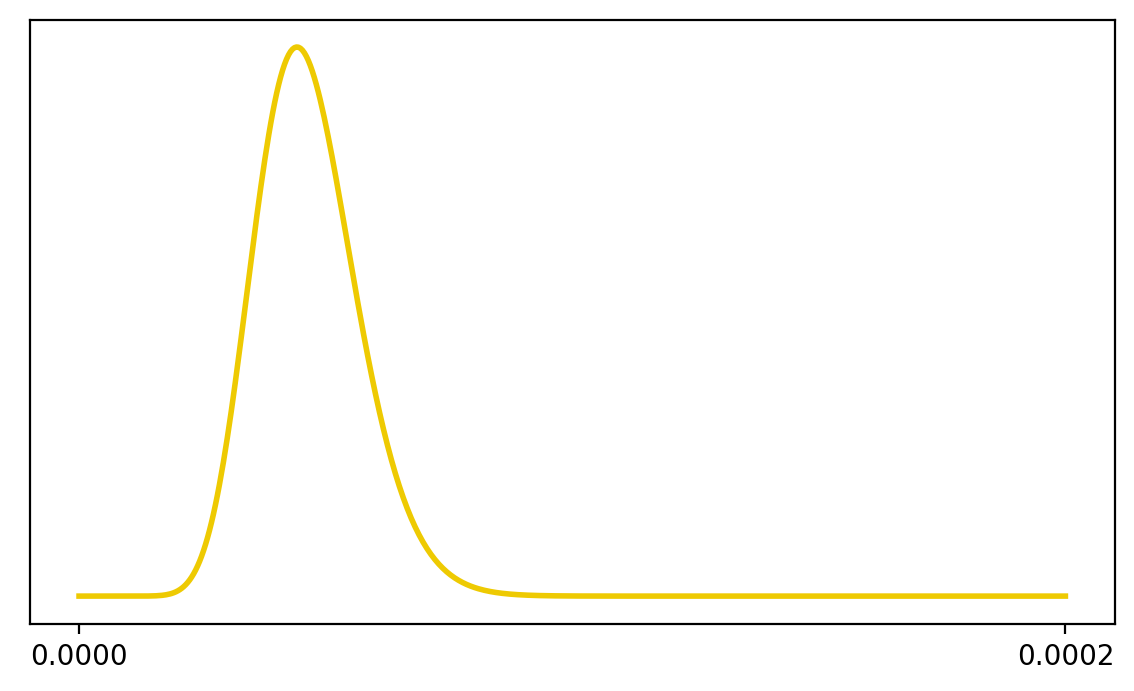

In [2]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
x2=np.linspace(0,20/1e5,500)
alpha=20
beta=430000
axes.plot(x2,stats.gamma.pdf(x2,a=alpha,scale=1/beta),color=dark,linewidth=2)
axes.set_yticks(())
axes.set_xticks([0,20/1e5])

plt.show()

## Prior predictive distribution

In [3]:
with open('cancer_ppc.stan', 'r') as file:
    print(file.read())

data {
  int pop; //population
}

generated quantities {
real theta = gamma_rng(20,430000);
int y = poisson_rng(10*theta*pop);
}



In [5]:
model_prior=CmdStanModel(stan_file='cancer_ppc.stan')

Using cached StanModel


In [8]:
R=1000
sim_data=dict(pop=1000)
sim_ppc=model_prior.sample(data=sim_data,
                          fixed_param=True,
                          iter_sampling=R, 
                          iter_warmup=0, 
                          chains=1, 
                          refresh=R,
                          seed=30042020)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


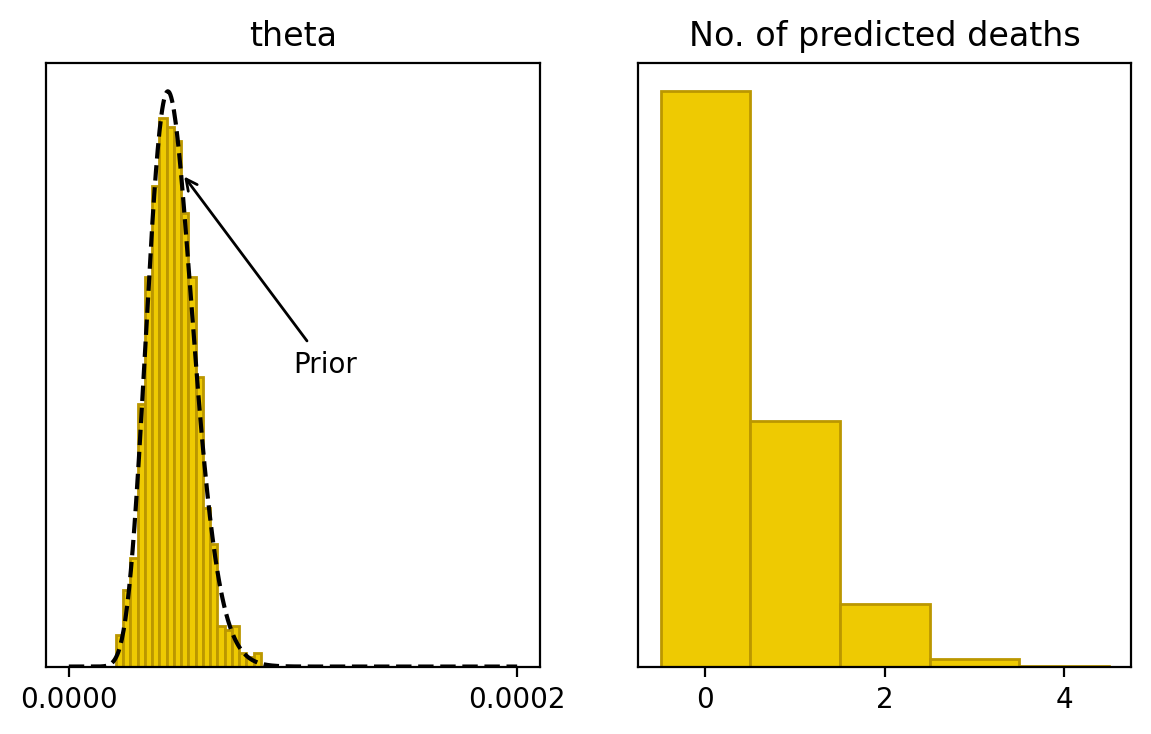

In [22]:

theta=sim_ppc.stan_variable('theta')
S_sim=sim_ppc.stan_variable('y')
prior_median=np.median(theta)
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax1=axes[0]
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.plot(x2,stats.gamma.pdf(x2,a=alpha,scale=1/beta),color='black',linestyle='--')
ax1.set_xticks([0,20/1e5])
ax1.set_yticks([])
ax1.set_title('theta')
ax1.annotate('Prior',xy=(5e-5,stats.gamma.pdf(5e-5,a=alpha,scale=1/beta)),xytext=(1e-4,2e4),arrowprops={'arrowstyle':'->'})
ax2=axes[1]
ax2.hist(S_sim,color=dark,edgecolor=dark_highlight,density=True,bins=np.linspace(-0.5,4.5,6))
ax2.set_yticks([])
ax2.set_title('No. of predicted deaths')
plt.show()

In [12]:
np.median(theta)

4.5939e-05

## Data 

In [23]:
counties_dc=pd.read_csv('counties_dc.csv',index_col=0)

dc=np.array(counties_dc.dc).astype('int')
pop=np.array(counties_dc.population).astype('int')
counties_dc.head()

,county,state,population,dc,obs_dr
0,Autauga,AL,34222,3.0,0.876629
1,Baldwin,AL,98280,22.0,2.238502
2,Barbour,AL,25417,1.0,0.393437
3,Bibb,AL,16576,1.0,0.603282
4,Blount,AL,39248,8.0,2.038320


## Posterior estimation and predictive distribution

In [24]:
with open('cancer_fit_singular.stan', 'r') as file:
    print(file.read())

data {
  int y; //observed cases at  observation
  int pop; //population at  observation
}

parameters {
  real<lower=0> theta;//estimated death parameters
}
transformed parameters {
  real<lower=0> lambda=10*pop * theta;
}

model {
  theta ~ gamma(20,430000);
  y ~ poisson(lambda);
}

generated quantities {
  int y_sim=0;
  y_sim = poisson_rng(lambda);
}



In [25]:
model2=CmdStanModel(stan_file='cancer_fit_singular.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpum4o6pzp/tmp6n2h8mun
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Volumes/My Book/iMac - non cloud/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 3 - One parameter models/Single parameters models/Kidney cancer/cancer_fit_singular


In [12]:
k=575
data = dict(y = dc[k],
            pop=pop[k])
fit = model2.sample(data=data, seed=26042020)

In [27]:
fit.diagnose()

INFO:cmdstanpy:Processing csv files: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp8f0vhh9f/cancer_fit_singular-202104241749-1-movhy8n0.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp8f0vhh9f/cancer_fit_singular-202104241749-2-rvyswf8n.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp8f0vhh9f/cancer_fit_singular-202104241749-3-moqd8g5q.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp8f0vhh9f/cancer_fit_singular-202104241749-4-8j0l3otm.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp8f0vhh9f/cancer_fit_singular-202104241749-1-movhy8n0.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp8f0vhh9f/cancer_fit_singular-202104241749-2-rvyswf8n.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp8f0vhh9f/cancer_fit_singular-202104241749-3-moqd8g5q.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp8f0vhh9f/cancer_fit_singular-202104241749-4-8j0l3otm.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [36]:
def estimate_death_rate(dc,pop):
    data = dict(y = int(dc),
                pop=int(pop))
    fit = model2.sample(data=data, seed=26042020)
    theta=fit.stan_variable('theta')
    y_sim=fit.stan_variable('y_sim')
    pred_dr=np.median(theta)
    pred_dr_err=az.hdi(theta,0.9)
    pred_dc=np.median(y_sim)
    pred_dc_err=az.hdi(y_sim,0.9)
    pred_dr_err_low=pred_dr_err[0]
    pred_dr_err_upp=pred_dr_err[1]
    pred_dc_err_low=pred_dc_err[0]
    pred_dc_err_upp=pred_dc_err[1]
    return pd.Series([pred_dr,
                      pred_dc,
                      pred_dr_err_low,
                      pred_dr_err_upp,
                      pred_dc_err_low,
                      pred_dc_err_upp],
                     index=['pred_dr',
                            'pred_dc',
                            'pred_dr_err_low',
                            'pred_dr_err_upp',
                            'pred_dc_err_low',
                            'pred_dc_err_upp'])


In [37]:

estimate_death_rate(dc[575],pop[575])

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


pred_dr               0.000021
pred_dc            1060.000000
pred_dr_err_low       0.000020
pred_dr_err_upp       0.000022
pred_dc_err_low     983.000000
pred_dc_err_upp    1133.000000
dtype: float64

In [38]:
import os.path
if os.path.exists('counts_and_estimates.csv'):
    counties_dc=pd.read_csv('counts_and_estimates.csv',index_col=0)
else:
    counties_dc[['pred_dr',
                 'pred_dc',
                 'pred_dr_err_low',
                 'pred_dr_err_upp',
                 'pred_dc_err_low',
                 'pred_dc_err_upp']] = counties_dc.apply(lambda x: estimate_death_rate(x.dc, x.population), axis=1)
    counties_dc.to_csv('counts_and_estimates.csv')
counties_dc.head()


FO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


,county,state,population,dc,obs_dr,pred_dr,pred_dc,pred_dr_err_low,pred_dr_err_upp,pred_dc_err_low,pred_dc_err_upp
0,Autauga,AL,34222,3.0,0.876629,0.000029,10.0,0.000019,0.000038,4.0,16.0
1,Baldwin,AL,98280,22.0,2.238502,0.000029,29.0,0.000022,0.000038,16.0,39.0
2,Barbour,AL,25417,1.0,0.393437,0.000030,8.0,0.000019,0.000041,3.0,13.0
3,Bibb,AL,16576,1.0,0.603282,0.000035,6.0,0.000023,0.000048,2.0,10.0
4,Blount,AL,39248,8.0,2.038320,0.000034,13.0,0.000024,0.000045,6.0,20.0


In [39]:
counties_dc[counties_dc.population==1000]

,county,state,population,dc,obs_dr,pred_dr,pred_dc,pred_dr_err_low,pred_dr_err_upp,pred_dc_err_low,pred_dc_err_upp
2392,Washabaugh,SD,1000,0.0,0.0,0.000045,0.0,0.000029,0.000064,0.0,1.0


In [40]:
counties_dc=counties_dc.sort_values(by='population')
obs_dr = np.array(counties_dc.dc)/np.array(counties_dc.population)/10
pred_dr = np.array(counties_dc.pred_dr)
errors = counties_dc.loc[:,'pred_dr_err_low':'pred_dr_err_upp'].to_numpy().T

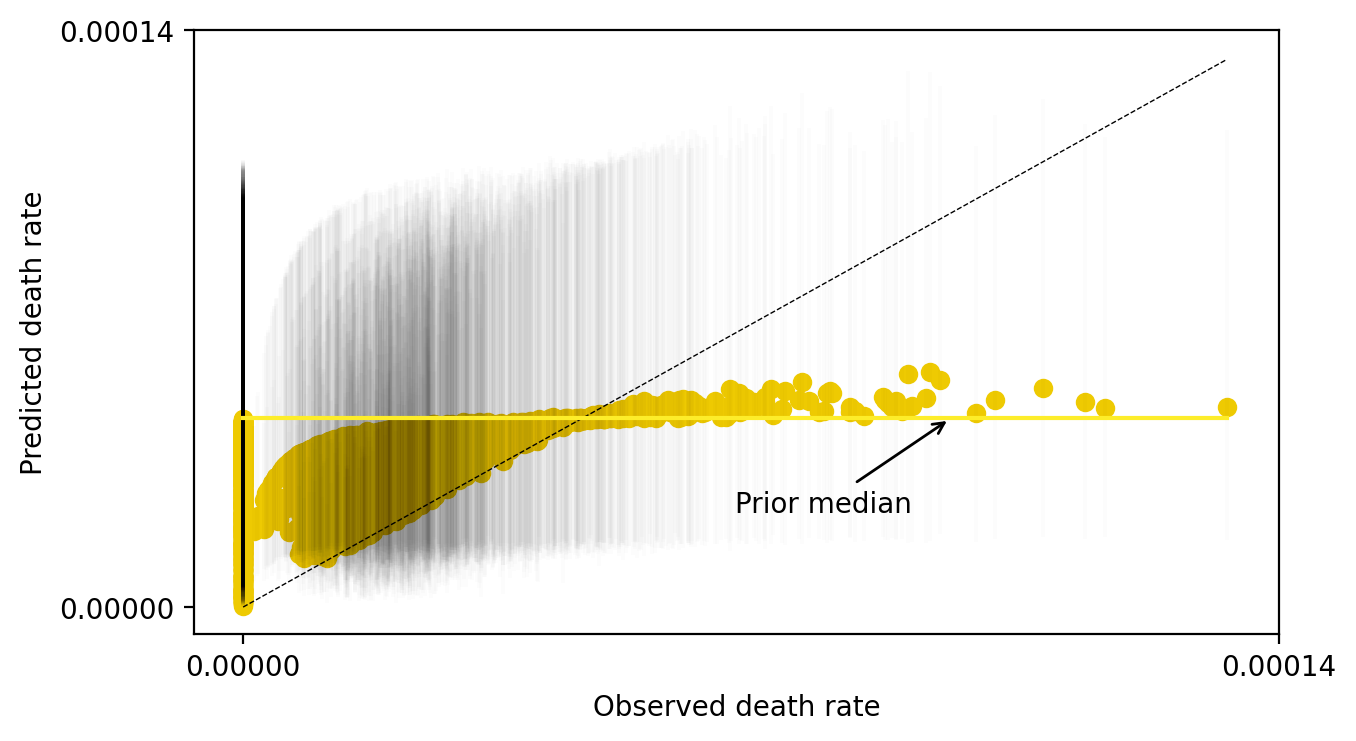

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.errorbar(obs_dr,pred_dr,yerr=errors,linestyle='none',color='black',alpha=0.01)
ax.scatter(obs_dr,pred_dr,color=dark)
ax.plot([0,np.max(obs_dr)],[0,np.max(obs_dr)],color='black',linestyle='--',linewidth=0.5)
ax.plot([0,np.max(obs_dr)],[prior_median,prior_median],color=mid)
ax.set_xlabel('Observed death rate')
ax.set_ylabel('Predicted death rate')
ax.set_xticks([0,0.00014])
ax.set_yticks([0,0.00014])
ax.annotate('Prior median',
            xy=(np.max(obs_dr)*0.72,prior_median),
            xytext=(np.max(obs_dr)*0.5,prior_median/2),
            arrowprops={'arrowstyle':'->'})
plt.show()

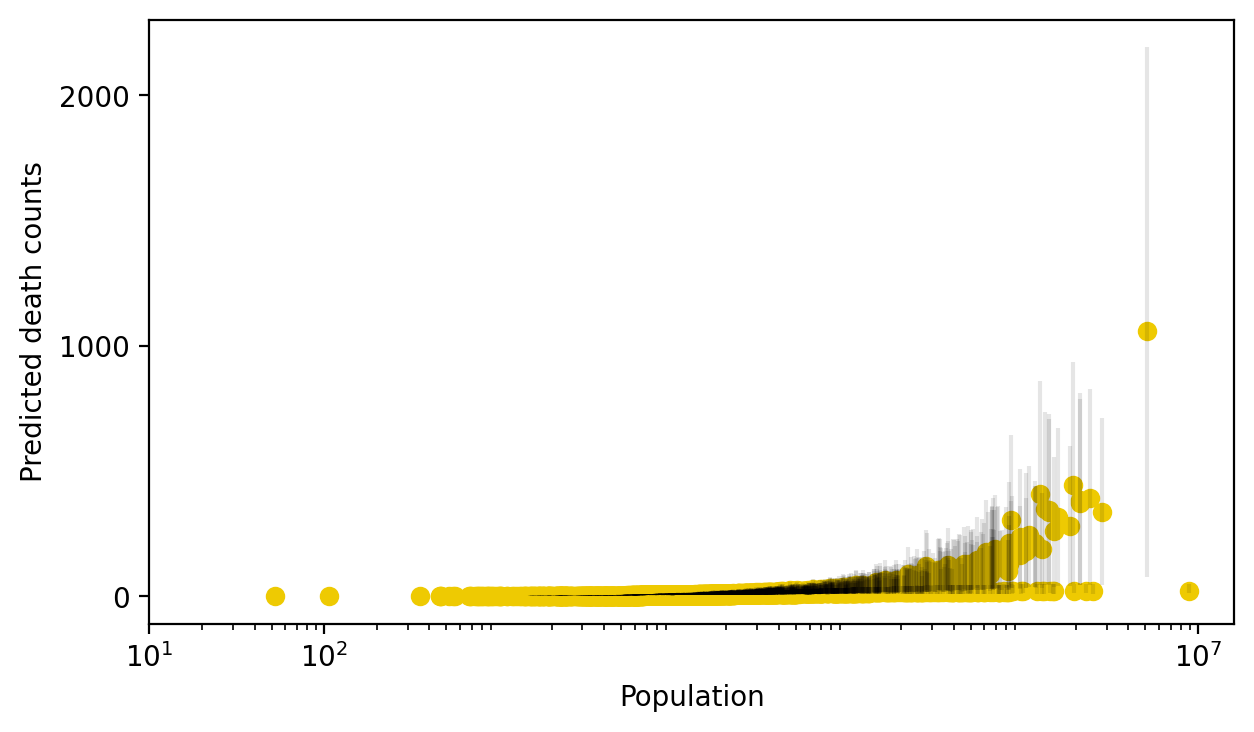

In [42]:
obs_dc = np.array(counties_dc.dc)
pred_dc = np.array(counties_dc.pred_dc)
errors2 = counties_dc.loc[:,'pred_dc_err_low':'pred_dc_err_upp'].to_numpy().T
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.set_xscale('log')

ax.errorbar(counties_dc.population,pred_dc,yerr=errors2,linestyle='none',color='black',alpha=0.1)
ax.scatter(counties_dc.population,pred_dc,color=dark)
ax.set_xlabel('Population')
ax.set_ylabel('Predicted death counts')
ax.set_xticks([10,100,1e7])
ax.set_yticks([0,1000,2000])
plt.show()

In [43]:
counties_dc[counties_dc.population>6e6]

,county,state,population,dc,obs_dr,pred_dr,pred_dc,pred_dr_err_low,pred_dr_err_upp,pred_dc_err_low,pred_dc_err_upp
175,Los angeles,CA,8863164,0.0,0.0,2.181810e-07,19.0,1.415020e-07,3.014770e-07,8.0,28.0


In [44]:
view= counties_dc[counties_dc.dc<25]
errors_v = view.loc[:,'pred_dc_err_low':'pred_dc_err_upp'].to_numpy().T

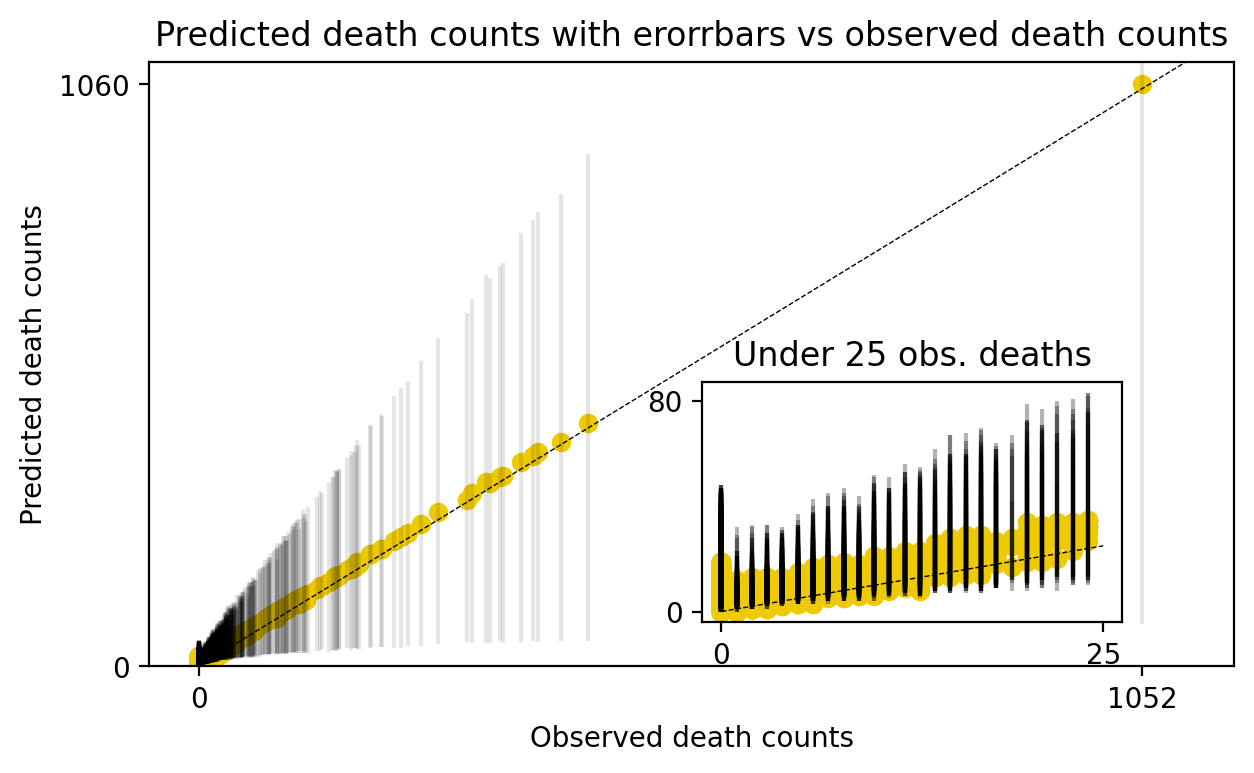

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.errorbar(obs_dc,pred_dc,yerr=errors2,linestyle='none',color='black',alpha=0.1)
ax.scatter(obs_dc,pred_dc,color=dark)
ax.plot([0,1100],[0,1100],color='black',linestyle='--',linewidth=0.5)
ax.set_ylim(0,1100)
ax.set_xlabel('Observed death counts')
ax.set_ylabel('Predicted death counts')
ax.set_title('Predicted death counts with erorrbars vs observed death counts')
ax.set_yticks([0,np.max(pred_dc)])
ax.set_xticks([0,np.max(obs_dc)])

ax_sm=plt.axes([0.52,0.18,0.3,0.3])
ax_sm.errorbar(view.dc,view.pred_dc,yerr=errors_v,linestyle='none',color='black',alpha=0.3)
ax_sm.scatter(view.dc,view.pred_dc,color=dark)
ax_sm.plot([0,25],[0,25],color='black',linestyle='--',linewidth=0.5)
ax_sm.set_xticks([0,25])
ax_sm.set_yticks([0,80])
ax_sm.set_title('Under 25 obs. deaths')
plt.show()